In [1]:
# Baixa e extrai o dataset
!mkdir data/
!curl -L -o data/animais.zip "https://drive.google.com/uc?export=download&id=16Lll0Slg1unWxAb26AzZqI9sPdB_fYpV"
!unzip data/animais.zip -d data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11.6M  100 11.6M    0     0  1728k      0  0:00:06  0:00:06 --:--:-- 3351k
Archive:  data/animais.zip
   creating: data/animais/
   creating: data/animais/val/
   creating: data/animais/val/tatu/
  inflating: data/animais/val/tatu/10242.jpg  
  inflating: data/animais/val/tatu/10209.jpg  
  inflating: data/animais/val/tatu/10251.jpg  
  inflating: data/animais/val/tatu/10202.jpg  
  inflating: data/animais/val/tatu/10243.jpg  
  inflating: data/animais/val/tatu/10215.jpg  
  inflating: data/animais/val/tatu/10254.jpg  
  inflating: data/animais/val/tatu/10241.jpg  
  inflating: data/animais/val/tatu/10238.jpg  
  inflating: data/animais/val/tatu/10228.jpg  
  inflating: data/animais/val/tatu/10203.jpg  
  inflating: data/animais/val/tatu/10236.jpg  

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
def train_model(model, trainloader, valloader, criterion, optimizer, device=device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader, device=device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [5]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data_dir = 'data/hymenoptera_data'
data_dir = "data/animais"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [6]:
model = models.resnet18()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

100%|██████████| 13/13 [01:51<00:00,  8.55s/it]
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Train Loss: 0.704, Train Accuracy: 51.25%
Epoch 1, Val Loss: 0.706, Val Accuracy: 47.54%


100%|██████████| 13/13 [02:05<00:00,  9.66s/it]


Epoch 2, Train Loss: 0.691, Train Accuracy: 54.00%
Epoch 2, Val Loss: 0.687, Val Accuracy: 56.56%


100%|██████████| 13/13 [02:04<00:00,  9.58s/it]


Epoch 3, Train Loss: 0.708, Train Accuracy: 51.50%
Epoch 3, Val Loss: 0.707, Val Accuracy: 52.46%


100%|██████████| 13/13 [01:54<00:00,  8.80s/it]


Epoch 4, Train Loss: 0.693, Train Accuracy: 55.25%
Epoch 4, Val Loss: 0.728, Val Accuracy: 45.08%


100%|██████████| 13/13 [01:49<00:00,  8.43s/it]


Epoch 5, Train Loss: 0.666, Train Accuracy: 59.25%
Epoch 5, Val Loss: 0.667, Val Accuracy: 59.02%
Treinamento concluído


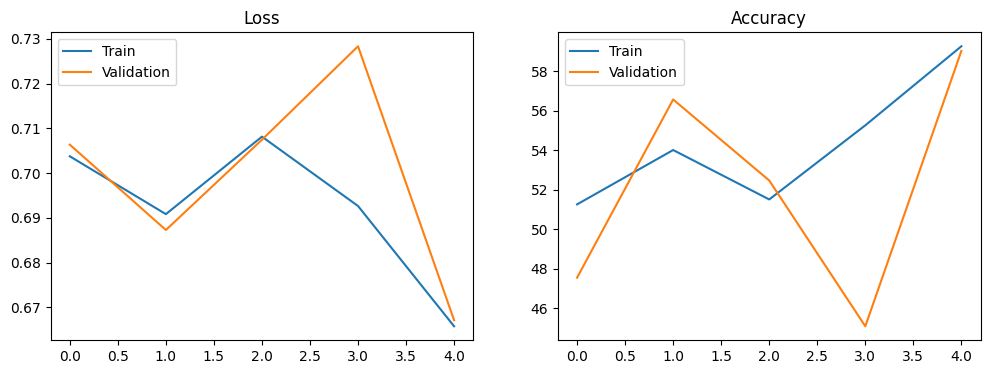

Acurácia da rede na base de teste: 59.02%


In [8]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)

In [9]:
# Utilizando pesos pré-treinados
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 92.8MB/s]


In [10]:
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False

In [11]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

100%|██████████| 13/13 [00:38<00:00,  2.96s/it]


Epoch 1, Train Loss: 0.572, Train Accuracy: 69.50%
Epoch 1, Val Loss: 0.387, Val Accuracy: 84.43%


100%|██████████| 13/13 [00:39<00:00,  3.02s/it]


Epoch 2, Train Loss: 0.422, Train Accuracy: 82.50%
Epoch 2, Val Loss: 0.268, Val Accuracy: 91.80%


100%|██████████| 13/13 [00:38<00:00,  2.99s/it]


Epoch 3, Train Loss: 0.308, Train Accuracy: 88.75%
Epoch 3, Val Loss: 0.212, Val Accuracy: 93.44%


100%|██████████| 13/13 [00:38<00:00,  2.99s/it]


Epoch 4, Train Loss: 0.333, Train Accuracy: 86.75%
Epoch 4, Val Loss: 0.214, Val Accuracy: 90.98%


100%|██████████| 13/13 [00:38<00:00,  2.99s/it]


Epoch 5, Train Loss: 0.244, Train Accuracy: 89.75%
Epoch 5, Val Loss: 0.166, Val Accuracy: 95.08%
Treinamento concluído


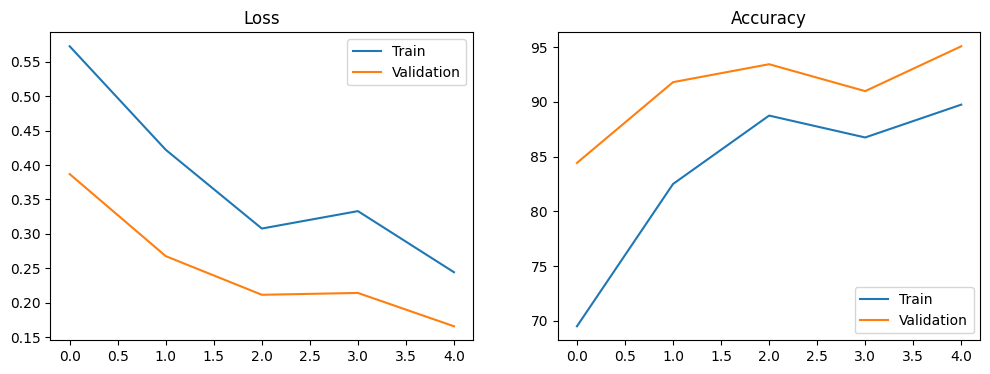

Acurácia da rede na base de teste: 95.08%


In [12]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)

In [13]:
def plot_and_predict(model, image, class_names, device=device):
    model.eval()
    image = image.to(device)
    outputs = model(image.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    probs = F.softmax(outputs, dim=1)[0] * 100
    prob = probs[predicted].item()

    # image between 0 and 1
    image = torch.clamp(image * 0.225 + 0.45, 0, 1)
    title = f'Classe: {class_names[predicted]} ({prob:.2f}%)'
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

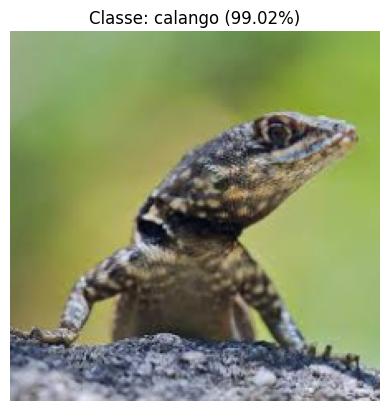

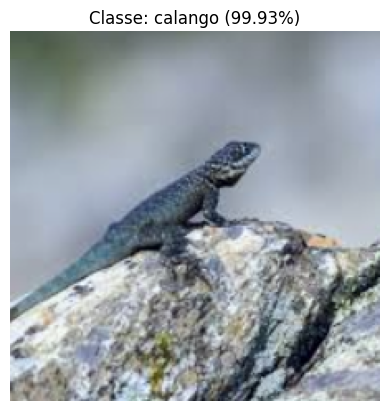

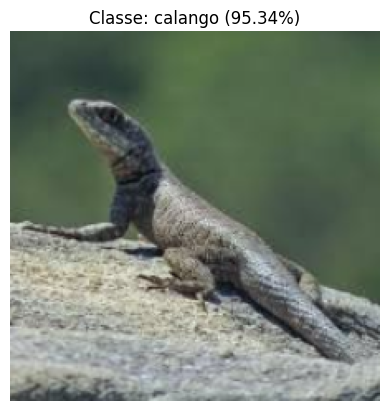

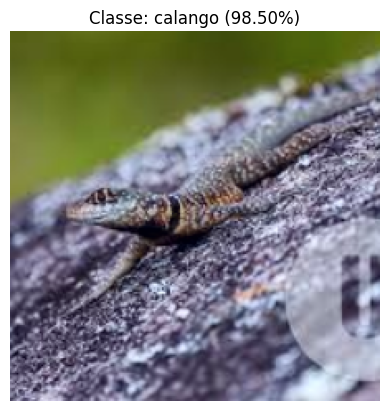

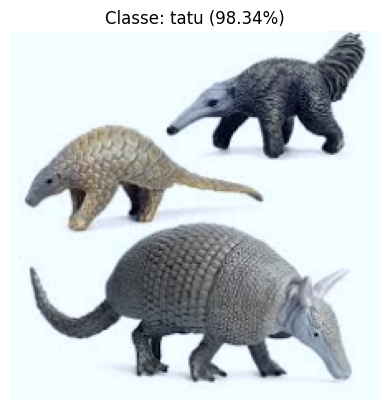

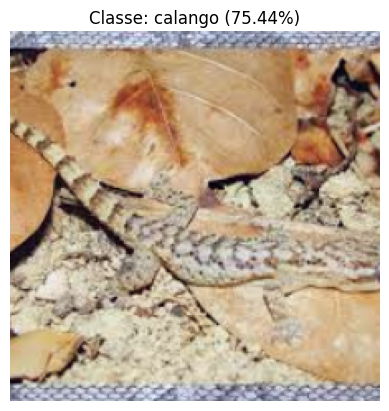

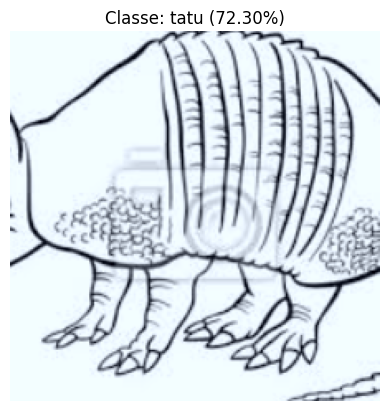

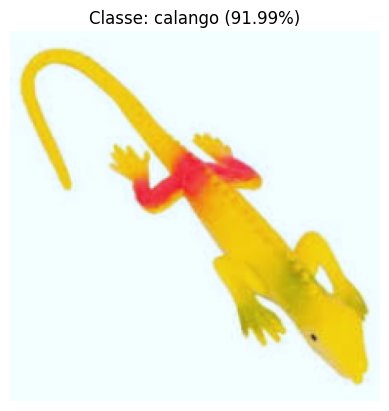

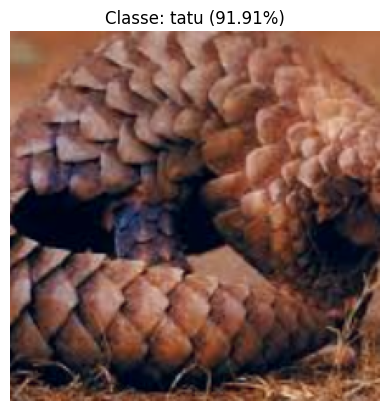

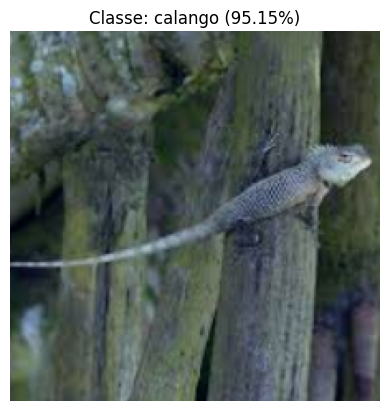

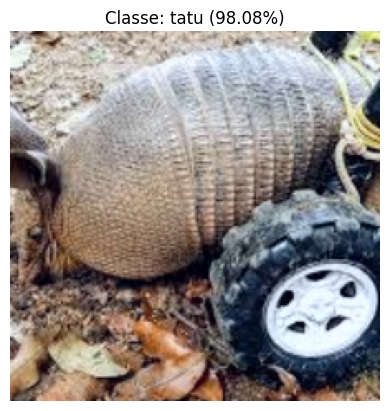

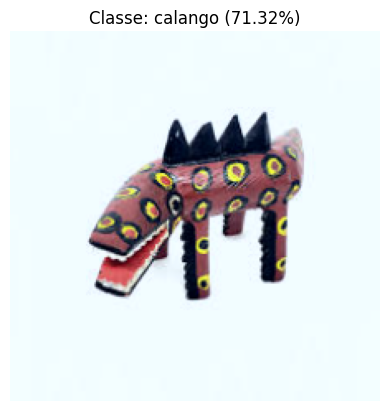

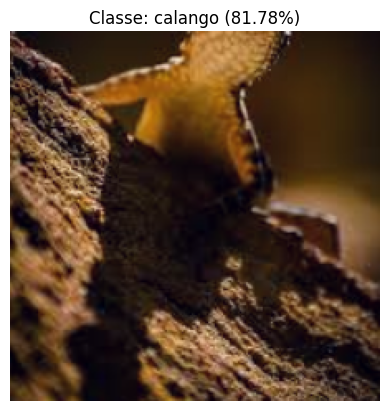

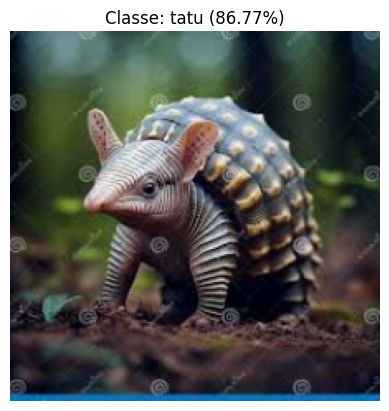

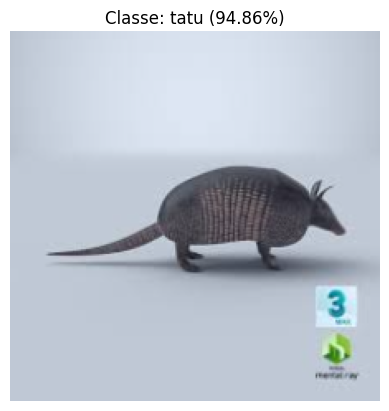

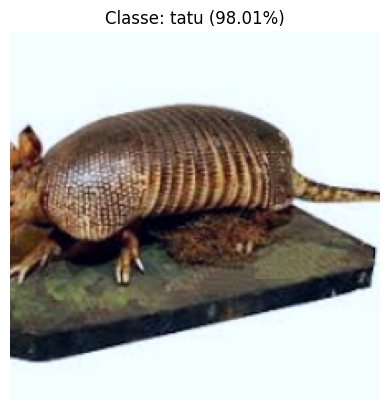

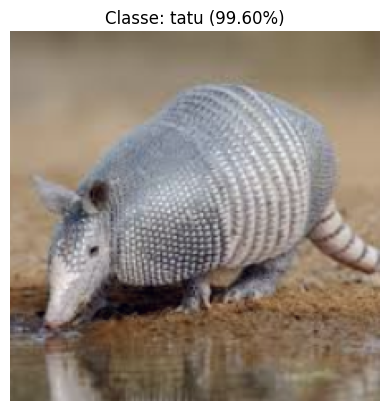

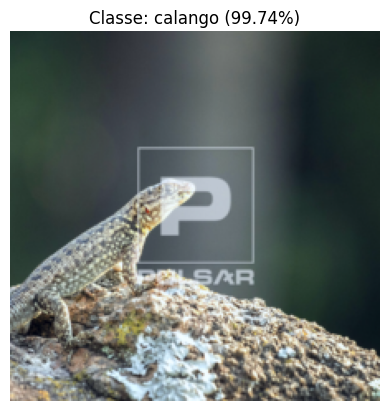

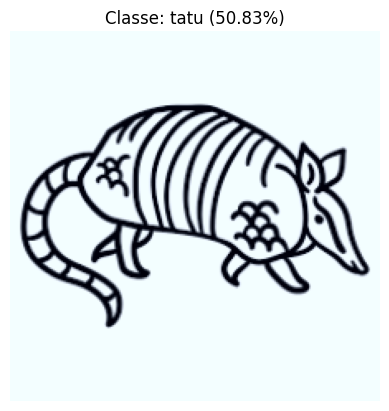

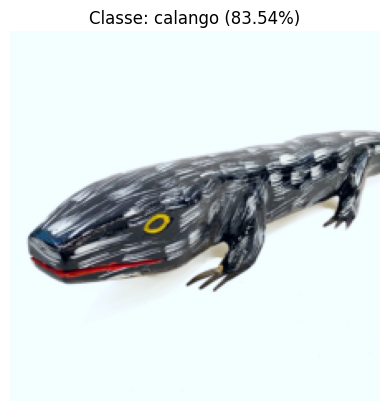

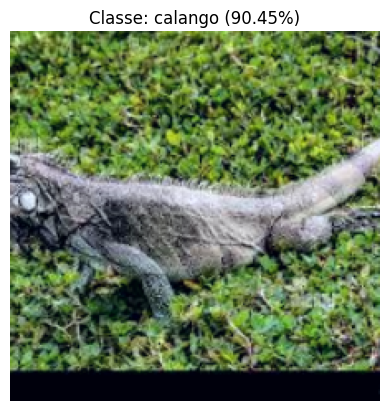

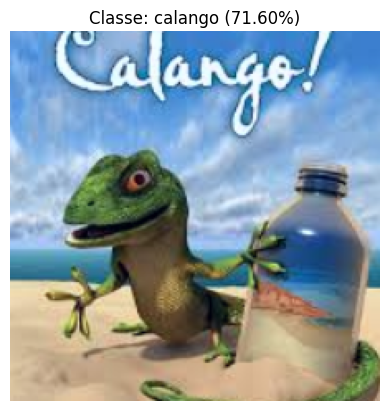

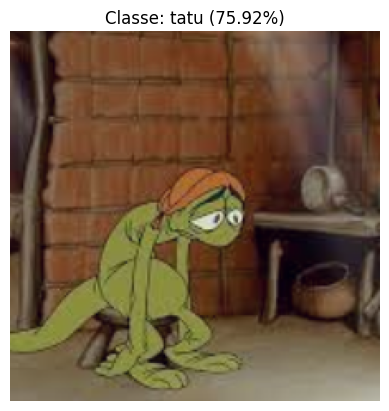

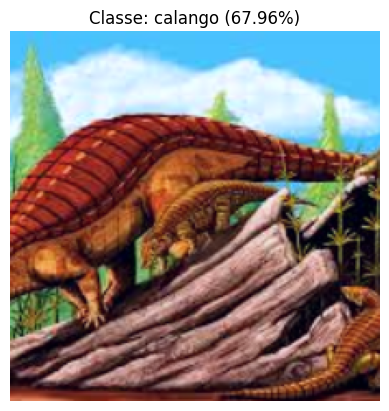

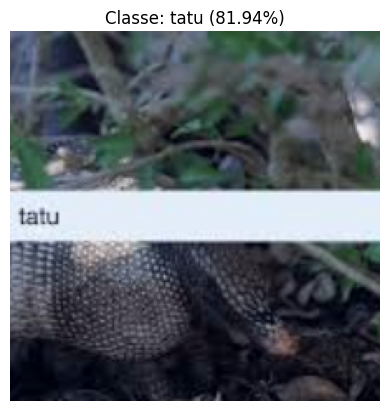

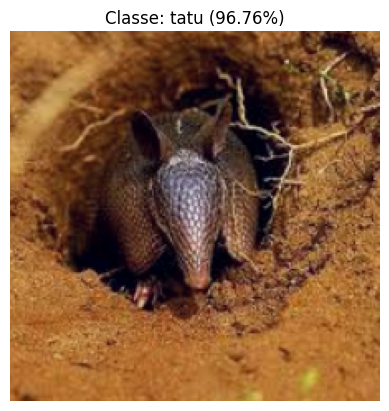

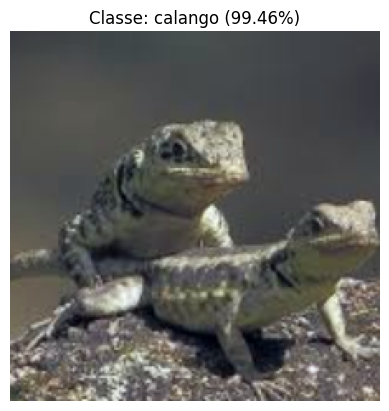

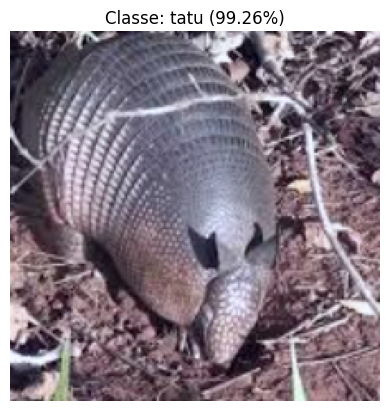

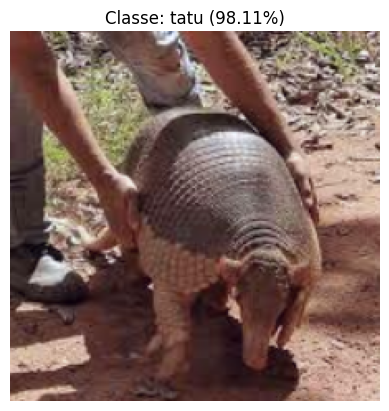

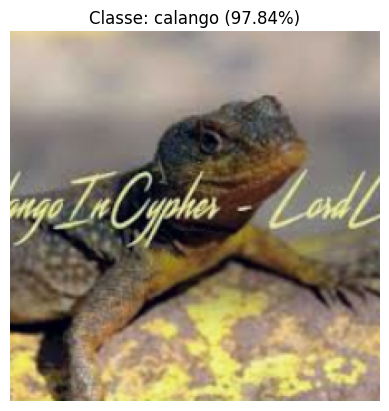

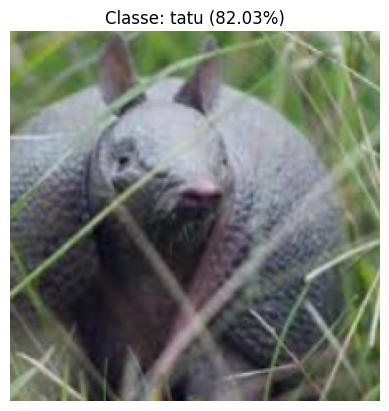

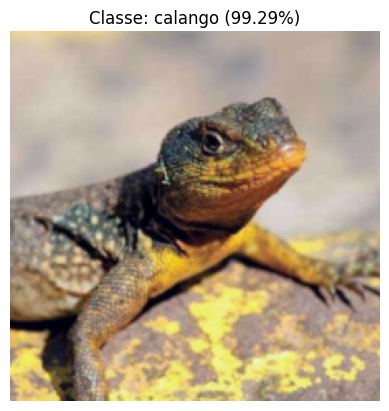

In [14]:
images, labels = next(iter(val_loader))

for image, label in zip(images, labels):
    plot_and_predict(model, image, val_set.classes)

## Exercícios

### Exercício 1
Treine novamente o modelo, mas sem data augmentation. Compare as curvas de treinamento de ambos os casos e comente.

In [15]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data_dir = 'data/hymenoptera_data'
data_dir = "data/animais"
train_set_no_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_no_aug)
#train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader_no_aug = DataLoader(train_set_no_aug, batch_size=32, shuffle=True)
#train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [16]:
model = models.resnet18()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

100%|██████████| 13/13 [01:51<00:00,  8.54s/it]


Epoch 1, Train Loss: 4.428, Train Accuracy: 30.25%
Epoch 1, Val Loss: 2.410, Val Accuracy: 54.92%


100%|██████████| 13/13 [01:50<00:00,  8.53s/it]


Epoch 2, Train Loss: 0.703, Train Accuracy: 53.50%
Epoch 2, Val Loss: 0.729, Val Accuracy: 44.26%


100%|██████████| 13/13 [01:48<00:00,  8.33s/it]


Epoch 3, Train Loss: 0.686, Train Accuracy: 54.75%
Epoch 3, Val Loss: 0.655, Val Accuracy: 62.30%


100%|██████████| 13/13 [01:47<00:00,  8.27s/it]


Epoch 4, Train Loss: 0.659, Train Accuracy: 58.00%
Epoch 4, Val Loss: 0.658, Val Accuracy: 57.38%


100%|██████████| 13/13 [01:48<00:00,  8.33s/it]


Epoch 5, Train Loss: 0.641, Train Accuracy: 64.50%
Epoch 5, Val Loss: 0.716, Val Accuracy: 57.38%
Treinamento concluído


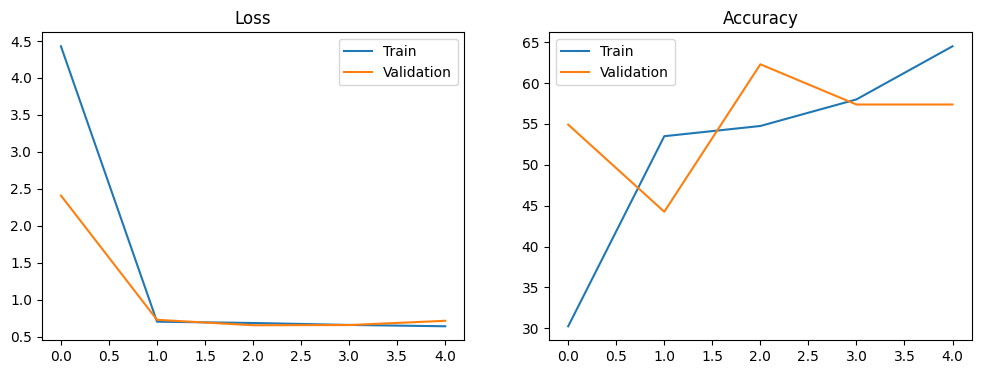

Acurácia da rede na base de teste: 57.38%


In [17]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader_no_aug, val_loader, criterion, optimizer, device, num_epochs=5)

#history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)

### Exercício 2
Descongele mais das últimas camadas (à sua escolha), por exemplo `model.layer4[1]`, e treine novamente o modelo.

In [18]:
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = True

In [19]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

100%|██████████| 13/13 [01:49<00:00,  8.40s/it]


Epoch 1, Train Loss: 0.746, Train Accuracy: 46.00%


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Val Loss: 0.701, Val Accuracy: 56.56%


100%|██████████| 13/13 [01:47<00:00,  8.31s/it]


Epoch 2, Train Loss: 0.698, Train Accuracy: 52.50%
Epoch 2, Val Loss: 0.658, Val Accuracy: 54.92%


100%|██████████| 13/13 [01:49<00:00,  8.44s/it]


Epoch 3, Train Loss: 0.685, Train Accuracy: 57.00%
Epoch 3, Val Loss: 0.644, Val Accuracy: 61.48%


100%|██████████| 13/13 [01:48<00:00,  8.37s/it]


Epoch 4, Train Loss: 0.683, Train Accuracy: 55.25%
Epoch 4, Val Loss: 0.641, Val Accuracy: 60.66%


100%|██████████| 13/13 [01:47<00:00,  8.25s/it]


Epoch 5, Train Loss: 0.656, Train Accuracy: 61.00%
Epoch 5, Val Loss: 0.652, Val Accuracy: 65.57%
Treinamento concluído


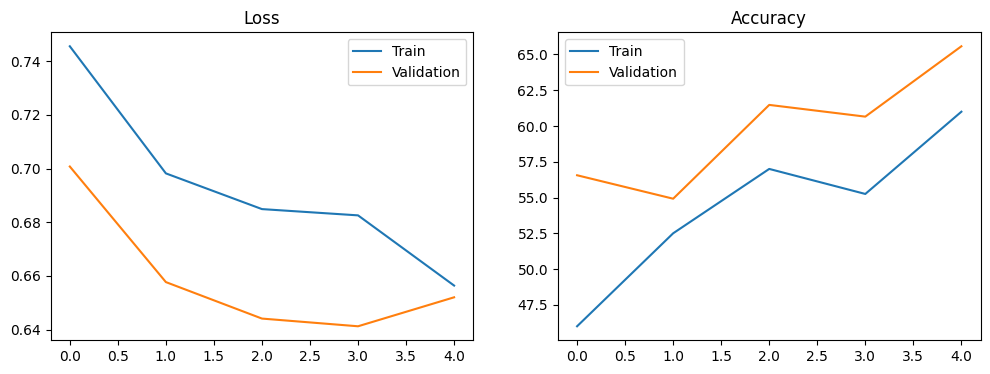

Acurácia da rede na base de teste: 65.57%


In [20]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)

### Exercício 3
Escolha outro modelo pré-treinado dos que foram vistos na aula e substitua no modelo. Lembre-se de alterar a última camada de classificação.

In [21]:
# Utilizando pesos pré-treinados
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 69.2MB/s]


In [22]:
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False

In [23]:
model.classifier[-1] = nn.Linear(4096, 2)
model = model.to(device)

100%|██████████| 13/13 [04:42<00:00, 21.75s/it]


Epoch 1, Train Loss: 0.519, Train Accuracy: 70.50%
Epoch 1, Val Loss: 0.158, Val Accuracy: 90.98%


100%|██████████| 13/13 [04:45<00:00, 21.97s/it]


Epoch 2, Train Loss: 0.213, Train Accuracy: 92.25%
Epoch 2, Val Loss: 0.152, Val Accuracy: 94.26%


100%|██████████| 13/13 [04:37<00:00, 21.37s/it]


Epoch 3, Train Loss: 0.181, Train Accuracy: 92.25%
Epoch 3, Val Loss: 0.128, Val Accuracy: 94.26%


100%|██████████| 13/13 [04:39<00:00, 21.53s/it]


Epoch 4, Train Loss: 0.197, Train Accuracy: 92.25%
Epoch 4, Val Loss: 0.134, Val Accuracy: 94.26%


100%|██████████| 13/13 [04:38<00:00, 21.41s/it]


Epoch 5, Train Loss: 0.182, Train Accuracy: 92.00%
Epoch 5, Val Loss: 0.120, Val Accuracy: 95.90%
Treinamento concluído


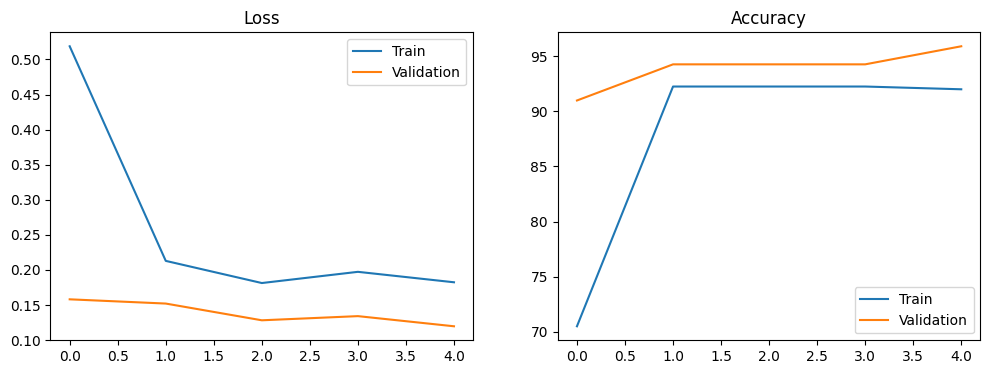

Acurácia da rede na base de teste: 95.90%


In [24]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)